In [1]:
# Preamble (system)
import sys
import os

if sys.version_info[0] < 3:
  raise AssertionError('Please run this notebook with Python 3.')

# Preamble (tools)
import numpy as np
import collections
import contextlib
import functools
import itertools
import more_itertools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Preamble (ML)
np.random.seed(2027)  # set random seed

#import tensorflow as tf
#tf.random.set_seed(2027)  # set random seed

#import dask
#import dask.array as da

In [2]:
# Preamble (EMTF)
from emtf_nbtools import (get_logger, get_colormap, hist2d_on_binned_data,
                          hist_on_binned_data, emtf_nbtools)

try:
  import emtf_nnet
except ImportError:
  raise ImportError('Could not import emtf_nnet. It can be found at '
                    'https://github.com/jiafulow/emtf-nnet')

# Get plot style and color map
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

# Get logger
logger = get_logger()
logger.info('Using cmssw      : {}'.format(os.environ.get('CMSSW_VERSION', 'N/A')))
logger.info('Using python     : {}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {}'.format(np.__version__))
logger.info('Using matplotlib : {}'.format(matplotlib.__version__))
#logger.info('Using tensorflow : {}'.format(tf.__version__))
#logger.info('Using keras      : {}'.format(tf.keras.__version__))
#logger.info('.. list devices  : {}'.format(tf.config.list_physical_devices()))
#logger.info('Using dask       : {}'.format(dask.__version__))
logger.info('Using emtf-nnet  : {}'.format(emtf_nnet.__version__))

[INFO    ] Using cmssw      : CMSSW_11_1_7
[INFO    ] Using python     : 3.9.7 (default, Sep 16 2021, 13:09:58) [GCC 7.5.0]
[INFO    ] Using numpy      : 1.20.3
[INFO    ] Using matplotlib : 3.4.2
[INFO    ] Using emtf-nnet  : 0.0.2-dev


In [3]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

maxevents = 200_000
#maxevents = -1

# Input files
signal_fname = 'signal.210808.npz'
signal_dxy_fname = 'signal_dxy.210808.npz'
bkgnd_fname = 'bkgnd.210808.npz'

logger.info('Using settings   : |')
logger.info('.. zone          : {}'.format(zone))
logger.info('.. timezone      : {}'.format(timezone))
logger.info('.. maxevents     : {}'.format(maxevents))

[INFO    ] Using settings   : |
[INFO    ] .. zone          : 0
[INFO    ] .. timezone      : 0
[INFO    ] .. maxevents     : 200000


### Load data

In [4]:
def load_signal(fname):
  logger.info('Loading from {}'.format(fname))
  with np.load(fname) as loaded:
    out_part = loaded['out_part']
    out_hits_values = loaded['out_hits_values']
    out_hits_row_splits = loaded['out_hits_row_splits']
    out_hits_shape = (out_hits_row_splits.shape[0] - 1,) + (None,) + out_hits_values.shape[1:]
    out_simhits_values = loaded['out_simhits_values']
    out_simhits_row_splits = loaded['out_simhits_row_splits']
    out_simhits_shape = (out_simhits_row_splits.shape[0] - 1,) + (None,) + out_simhits_values.shape[1:]
  logger.info('out_part: {}, out_hits: {}, out_simhits: {}'.format(
      (out_part.shape, out_part.dtype.name),
      (out_hits_shape, out_hits_values.dtype.name),
      (out_simhits_shape, out_simhits_values.dtype.name)))
  return (out_part, (out_hits_values, out_hits_row_splits), (out_simhits_values, out_simhits_row_splits))


def load_bkgnd(fname):
  logger.info('Loading from {}'.format(fname))
  with np.load(fname) as loaded:
    bkg_aux = loaded['out_aux']
    bkg_hits_values = loaded['out_hits_values']
    bkg_hits_row_splits = loaded['out_hits_row_splits']
    bkg_hits_shape = (bkg_hits_row_splits.shape[0] - 1,) + (None,) + bkg_hits_values.shape[1:]
  logger.info('bkg_aux: {} bkg_hits: {}'.format(
      (bkg_aux.shape, bkg_aux.dtype.name),
      (bkg_hits_shape, bkg_hits_values.dtype.name)))
  return (bkg_aux, (bkg_hits_values, bkg_hits_row_splits))

In [5]:
# Load data
out_part, out_hits, out_simhits = load_signal(signal_fname)

bkg_aux, bkg_hits = load_bkgnd(bkgnd_fname)

out_hits = emtf_nnet.ragged.RaggedTensorValue(out_hits[0], out_hits[1])
out_simhits = emtf_nnet.ragged.RaggedTensorValue(out_simhits[0], out_simhits[1])
bkg_hits = emtf_nnet.ragged.RaggedTensorValue(bkg_hits[0], bkg_hits[1])

[INFO    ] Loading from signal.210808.npz
[INFO    ] out_part: ((2000000, 10), 'float32'), out_hits: ((2000000, None, 17), 'int32'), out_simhits: ((2000000, None, 17), 'int32')
[INFO    ] Loading from bkgnd.210808.npz
[INFO    ] bkg_aux: ((136104, 2), 'int32') bkg_hits: ((136104, None, 17), 'int32')


### More settings

In [6]:
# Imported from emtf_algos.py

# 2 endcaps, 6 sectors per endcap. 3 zones and 3 timezones per sector.
num_emtf_sectors = 12
num_emtf_zones = 3
num_emtf_timezones = 3

num_emtf_sites = 12
num_emtf_sites_rm = 5
num_emtf_hosts = 19

# Full range of emtf_phi is assumed to be 0..5040 (0..84 deg).
# 84 deg from 60 (native) + 20 (neighbor) + 2 (tolerance, left) + 2 (tolerance, right).
coarse_emtf_strip = 8 * 2  # 'doublestrip' unit
min_emtf_strip = (315 - 288) * coarse_emtf_strip  # 7.2 deg
max_emtf_strip = (315 - 0) * coarse_emtf_strip  # 84 deg

img_row_labels = np.array([
  ['ME0'  , 'GE1/1', 'ME1/1', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1'],
  ['GE1/1', 'ME1/1', 'ME1/2', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1'],
  ['ME1/2', 'RE1/2', 'RE2/2', 'ME2/2', 'ME3/2', 'RE3/2', 'ME4/2', 'RE4/2'],
], dtype=str)


# Encode EMTF zone image row
def find_emtf_img_row_lut():
  # From closest to furthest:
  # ME0
  # GE1/1, ME1/1, ME1/2, RE1,
  # GE2/1, RE2, ME2,
  # ME3, RE3,
  # ME4, RE4,
  default_value = -99
  lut = np.full((num_emtf_hosts, num_emtf_zones), default_value, dtype=np.int32)  # (host,zone) -> row
  lut[0,0] = 2   # ME1/1
  lut[3,0] = 4   # ME2/1
  lut[5,0] = 5   # ME3/1
  lut[7,0] = 7   # ME4/1
  lut[9,0] = 1   # GE1/1
  lut[12,0] = 3  # GE2/1
  lut[14,0] = 6  # RE3/1
  lut[16,0] = 7  # RE4/1
  lut[18,0] = 0  # ME0
  #
  lut[0,1] = 1   # ME1/1
  lut[1,1] = 2   # ME1/2
  lut[3,1] = 4   # ME2/1
  lut[5,1] = 5   # ME3/1
  lut[6,1] = 5   # ME3/2
  lut[7,1] = 7   # ME4/1
  lut[8,1] = 7   # ME4/2
  lut[9,1] = 0   # GE1/1
  lut[10,1] = 2  # RE1/2
  lut[12,1] = 3  # GE2/1
  lut[14,1] = 6  # RE3/1
  lut[15,1] = 6  # RE3/2
  lut[16,1] = 7  # RE4/1
  lut[17,1] = 7  # RE4/2
  #
  lut[1,2] = 0   # ME1/2
  lut[4,2] = 3   # ME2/2
  lut[6,2] = 4   # ME3/2
  lut[8,2] = 6   # ME4/2
  lut[10,2] = 1  # RE1/2
  lut[13,2] = 2  # RE2/2
  lut[15,2] = 5  # RE3/2
  lut[17,2] = 7  # RE4/2
  return lut


def find_emtf_img_row_initializer():
  lut = find_emtf_img_row_lut()

  def lookup(emtf_host, zone):
    emtf_host = np.asarray(emtf_host)
    zone = np.asarray(zone)
    if zone.ndim != 0:
      raise ValueError('zone should be a scalar.')
    item = np.take(lut[:, zone], emtf_host)
    return item
  return lookup


# The initializer will instantiate the lookup table
find_emtf_img_row = find_emtf_img_row_initializer()


def find_emtf_img_col(emtf_phi):
  emtf_phi = np.asarray(emtf_phi)
  return (emtf_phi - min_emtf_strip) // coarse_emtf_strip


def save_np_arrays(outfile, outdict):
  np.savez_compressed(outfile, **outdict)

In [7]:
# particle info
_part_fields = [
  'part_invpt',
  'part_eta',
  'part_phi',
  'part_vx',
  'part_vy',
  'part_vz',
  'part_d0',
  'part_bx',
  'part_sector',
  'part_zone',
]
PartFields = collections.namedtuple('PartFields', _part_fields)
part_fields = PartFields(*range(len(_part_fields)))

# sector_hits info
_sector_hits_fields = [
  'emtf_chamber',
  'emtf_segment',
  'emtf_phi',
  'emtf_bend',
  'emtf_theta1',
  'emtf_theta2',
  'emtf_qual1',
  'emtf_qual2',
  'emtf_time',
  'zones',
  'timezones',
  'cscfr',
  'gemdl',
  'bx',
  'emtf_site',
  'emtf_host',
  'valid',
]
SectorHitsFields = collections.namedtuple('SectorHitsFields', _sector_hits_fields)
sector_hits_fields = SectorHitsFields(*range(len(_sector_hits_fields)))

In [8]:
# Info regarding phi unit
# 80 deg is converted to (80.*60)/16 = 300 units.
# 30 deg is converted to (30.*60)/16 = 112.5 units.
# 300 units aligned to 16-bit is np.floor(300./16)*16 = 288 units.
# 112.5 units aligned to 16-bit is np.floor(112.5/16) * 16 = 112 units,
# 112 is then lowered to the closest odd number 111.

# Image format
num_channels = 1
num_cols = 288  # 80 degrees
num_rows = 8
image_format = (num_rows, num_cols, num_channels)
image_stride = (min_emtf_strip, max_emtf_strip, coarse_emtf_strip)
assert ((max_emtf_strip - min_emtf_strip) // coarse_emtf_strip) == num_cols

# Box image format
num_box_rows = num_rows
num_box_cols = 111  # 30 degrees
num_box_channels = num_channels
box_image_format = (num_box_rows, num_box_cols, num_box_channels)
box_col_offset = (num_box_cols - 1) // 2  # (111-1)/2 = 55
box_col_padding = 36  # ad-hoc, reduces pattern winsz to ~20 deg
assert (num_box_cols % 2) == 1

# Zone-dependent settings
if zone == 0:
  invpt_bins = np.array([-0.49486, -0.30914, -0.18457, -0.06144,  0.06144,  0.18457,  0.30914,  0.49486])
  dzero_bins = np.array([-149.05426 ,  -81.995094,  -27.704363,   -3.316771,    3.316771,   27.704363,   81.995094,  149.05426 ])
  anchor_row = 4  # ME2/1
  activation = 0.06
elif zone == 1:
  invpt_bins = np.array([-0.4943 , -0.32499, -0.20098, -0.06069,  0.06069,  0.20098,  0.32499,  0.4943 ])
  dzero_bins = np.array([-148.39244 ,  -75.48091 ,  -24.779198,   -2.740005,    2.740005,   24.779198,   75.48091 ,  148.39244 ])
  anchor_row = 4  # ME2/1
  activation = 0.06
elif zone == 2:
  invpt_bins = np.array([-0.46452, -0.25713, -0.15333, -0.06148,  0.06148,  0.15333,  0.25713,  0.46452])
  dzero_bins = np.array([-148.38953 ,  -73.95163 ,  -24.58335 ,   -3.207681,    3.207681,   24.58335 ,   73.95163 ,  148.38953 ])
  anchor_row = 3  # ME2/2
  activation = 0.05
else:
  raise RuntimeError('Could not recognize zone: {}'.format(zone))

num_invpt_bins = len(invpt_bins) - 1
num_dzero_bins = len(dzero_bins) - 1


def digitize_d0_and_invpt(d0, invpt):
  # returns (dzero_bin, invpt_bin)
  idx0 = emtf_nbtools.hist_digitize_inclusive(d0, dzero_bins)
  idx1 = emtf_nbtools.hist_digitize_inclusive(invpt, invpt_bins)
  return (idx0, idx1)

### Zone selection

In [9]:
# Make and apply zone_mask

part_zone = out_part[:, part_fields.part_zone].astype(np.int32)
zone_mask = (part_zone == zone)

eta_1p0_2p4_mask = ((1.0 <= np.abs(out_part[:, part_fields.part_eta])) &
                    (np.abs(out_part[:, part_fields.part_eta]) <= 2.4))
zone_mask &= eta_1p0_2p4_mask

atleast_1hit_mask = (out_simhits.row_lengths != 0)
zone_mask &= atleast_1hit_mask

zone_part = out_part[zone_mask]
zone_hits = emtf_nnet.ragged.ragged_row_boolean_mask(out_hits, zone_mask)
zone_simhits = emtf_nnet.ragged.ragged_row_boolean_mask(out_simhits, zone_mask)

logger.info('zone_part: {} zone_hits: {} zone_simhits: {}'.format(
    zone_part.shape, zone_hits.shape, zone_simhits.shape))

[INFO    ] zone_part: (692352, 10) zone_hits: (692352, None, 17) zone_simhits: (692352, None, 17)


In [10]:
# Debug
with np.printoptions(linewidth=100, threshold=1000):
  for ievt in range(5):
    print('Event {}'.format(ievt))
    print(zone_part[ievt])
    print(zone_hits[ievt])
    print(zone_simhits[ievt])

Event 0
[ 3.7416764e-02 -2.0811100e+00 -1.3405307e-01  1.3609688e-03  9.8792014e-05 -3.1927819e+00
 -2.7980140e-04  0.0000000e+00  1.1000000e+01  0.0000000e+00]
[[   9    0 3534    0   20   19    6   10    0    4    4    1    0    0    0    0    1]
 [   9    1 3534    0   20   19    6   10    0    4    4    1    0    0    0    0    1]
 [  19    0 3440    0   19    0    6   10    0    4    4    1    0    0    2    3    1]
 [  28    0 3432    0   19   19    6   10    0    4    4    0    0    0    3    5    1]
 [  28    1 3432    0   19   19    6   10    0    4    4    0    0    0    3    5    1]
 [  37    0 3464   -4   20   19    6    9    0    4    4    0    0    0    4    7    1]
 [  37    1 3464   -4   20   19    6    9    0    4    4    0    0    0    4    7    1]
 [  63    0 3468    0   21    0    0    0    0    4    4    1    1    0    9    9    1]
 [  73    0 3443    0   19    0    0    0    0    4    4    1    1    0   10   12    1]
 [  82    0 3433    0   20    0    0    0    0 

### Build images

In [11]:
# Build images

def build_zone_images():
  # zone_images_gt are made from sim hits, while zone_images are made from trigger primitives.
  # 'gt' stands for ground truth.
  zone_images_gt = np.zeros((zone_part.shape[0],) + image_format, dtype=bool)
  zone_images = np.zeros((zone_part.shape[0],) + image_format, dtype=bool)

  # Get hit variables
  zone_simhits_row_splits = zone_simhits.row_splits
  zone_simhits_emtf_phi = zone_simhits.values[:, sector_hits_fields.emtf_phi]
  zone_simhits_emtf_host = zone_simhits.values[:, sector_hits_fields.emtf_host]
  zone_simhits_zones = zone_simhits.values[:, sector_hits_fields.zones]
  zone_simhits_timezones = zone_simhits.values[:, sector_hits_fields.timezones]
  zone_simhits_valid = zone_simhits.values[:, sector_hits_fields.valid].astype(bool)

  zone_hits_row_splits = zone_hits.row_splits
  zone_hits_emtf_phi = zone_hits.values[:, sector_hits_fields.emtf_phi]
  zone_hits_emtf_host = zone_hits.values[:, sector_hits_fields.emtf_host]
  zone_hits_zones = zone_hits.values[:, sector_hits_fields.zones]
  zone_hits_timezones = zone_hits.values[:, sector_hits_fields.timezones]
  zone_hits_valid = zone_hits.values[:, sector_hits_fields.valid].astype(bool)

  # Perform (vectorized) calculations
  zone_simhits_valid = ((zone_simhits_zones & (1 << ((num_emtf_zones - 1) - zone))).astype(bool) &
                        (zone_simhits_timezones & (1 << ((num_emtf_timezones - 1) - timezone))).astype(bool) &
                        zone_simhits_valid)
  zone_simhits_img_row = find_emtf_img_row(zone_simhits_emtf_host, zone=zone)
  zone_simhits_img_col = find_emtf_img_col(zone_simhits_emtf_phi)

  zone_hits_valid = ((zone_hits_zones & (1 << ((num_emtf_zones - 1) - zone))).astype(bool) &
                     (zone_hits_timezones & (1 << ((num_emtf_timezones - 1) - timezone))).astype(bool) &
                     zone_hits_valid)
  zone_hits_img_row = find_emtf_img_row(zone_hits_emtf_host, zone=zone)
  zone_hits_img_col = find_emtf_img_col(zone_hits_emtf_phi)

  # Build zone_images_gt
  _build_zone_images(zone_simhits_row_splits,
                     zone_simhits_valid,
                     zone_simhits_img_row,
                     zone_simhits_img_col,
                     zone_images_gt)
  # Build zone_images
  _build_zone_images(zone_hits_row_splits,
                     zone_hits_valid,
                     zone_hits_img_row,
                     zone_hits_img_col,
                     zone_images)
  return (zone_images_gt, zone_images)


def _build_zone_images(zone_simhits_row_splits,
                       zone_simhits_valid,
                       zone_simhits_img_row,
                       zone_simhits_img_col,
                       zone_images_gt):
  # If valid, set bit at (row, col, channel) to 1
  def func(ievt, valid, row, col):
    if valid and (row >= 0) and (col >= 0):
      zone_images_gt[ievt, row, col, 0] = 1

  zone_simhits_row_indices = emtf_nnet.ragged.ragged_row_splits_to_segment_ids(zone_simhits_row_splits)
  iterables = zip(zone_simhits_row_indices, zone_simhits_valid, zone_simhits_img_row, zone_simhits_img_col)
  more_itertools.consume(itertools.starmap(func, iterables))

In [12]:
# Display images

def display_zone_image(img, cmap=cm.blue_hot, figsize=(10,2)):
  fig, ax = plt.subplots(figsize=figsize)
  ax.imshow(img[..., 0], origin='lower', interpolation='none', aspect='auto', cmap=cmap,
            vmin=0, vmax=1.6)
  ax.set_yticks(range(len(img_row_labels[zone])))
  ax.set_yticklabels(img_row_labels[zone], fontsize=7)
  ax.grid(False)
  plt.show()

In [13]:
%%time

zone_images_gt, zone_images = build_zone_images()

logger.info('zone_images_gt: {} zone_images: {}'.format(zone_images_gt.shape, zone_images.shape))

[INFO    ] zone_images_gt: (692352, 8, 288, 1) zone_images: (692352, 8, 288, 1)


CPU times: user 36.5 s, sys: 1.33 s, total: 37.9 s
Wall time: 37.9 s


In [14]:
# Remake zone_mask

# Reduce on axis=(-2,-1), then count on axis=-3 (row)
atleast_2rows_mask = (zone_images_gt.any(axis=-1).any(axis=-1).sum(axis=-1) >= 2)
zone_mask = atleast_2rows_mask

zone_part = zone_part[zone_mask]
zone_hits = emtf_nnet.ragged.ragged_row_boolean_mask(zone_hits, zone_mask)
zone_simhits = emtf_nnet.ragged.ragged_row_boolean_mask(zone_simhits, zone_mask)

zone_images_gt = zone_images_gt[zone_mask]
zone_images = zone_images[zone_mask]

zone_part_pt_values = np.reciprocal(np.abs(zone_part[:, part_fields.part_invpt]))
zone_part_eta_values = zone_part[:, part_fields.part_eta]

logger.info('zone_images_gt: {} zone_images: {}'.format(zone_images_gt.shape, zone_images.shape))

[INFO    ] zone_images_gt: (691542, 8, 288, 1) zone_images: (691542, 8, 288, 1)


Event 0
pt: 26.726 eta: -2.081


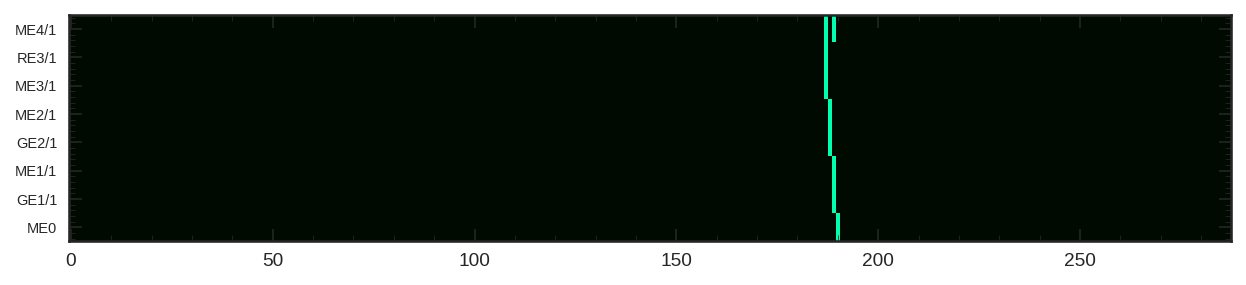

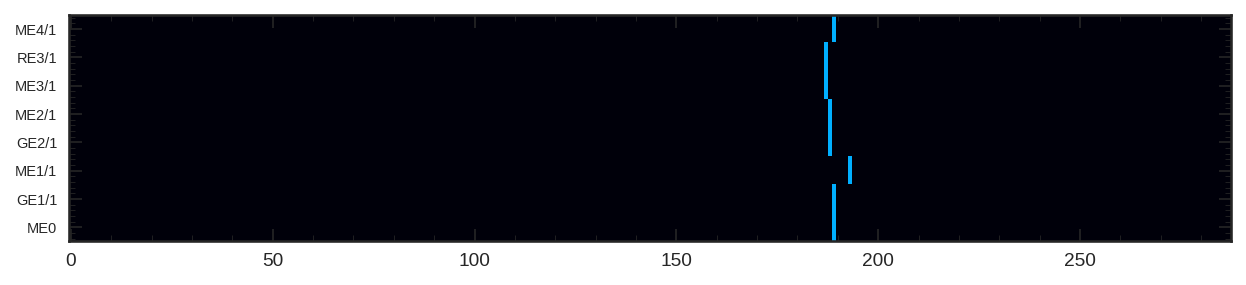

Event 1
pt: 2.550 eta: -2.306


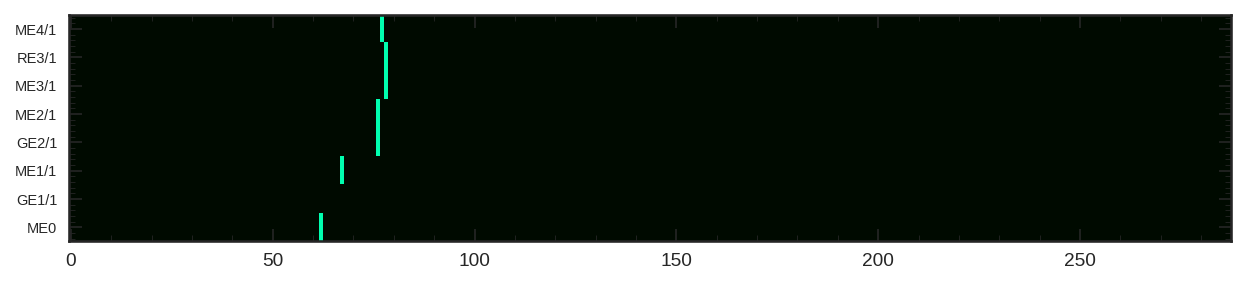

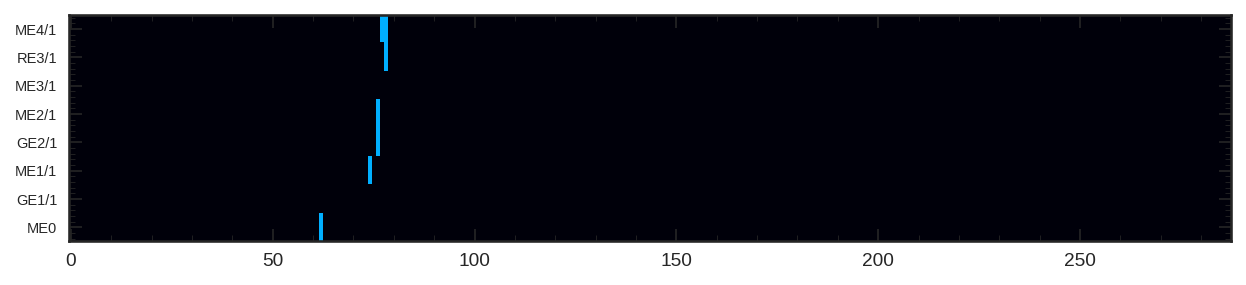

Event 2
pt: 3.003 eta: -2.355


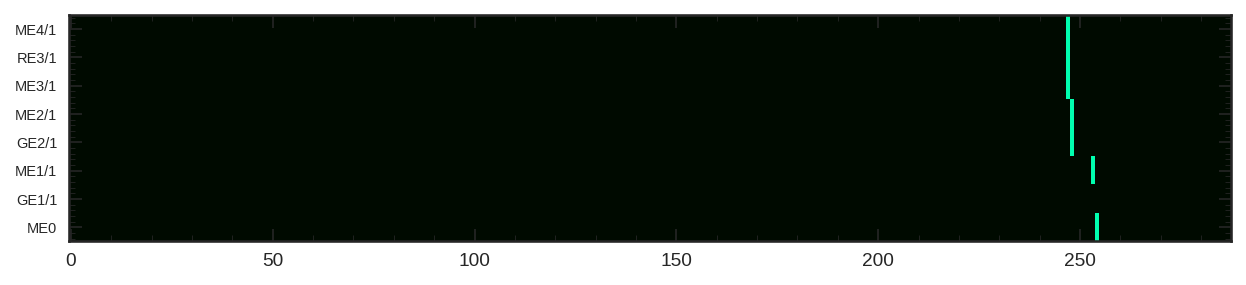

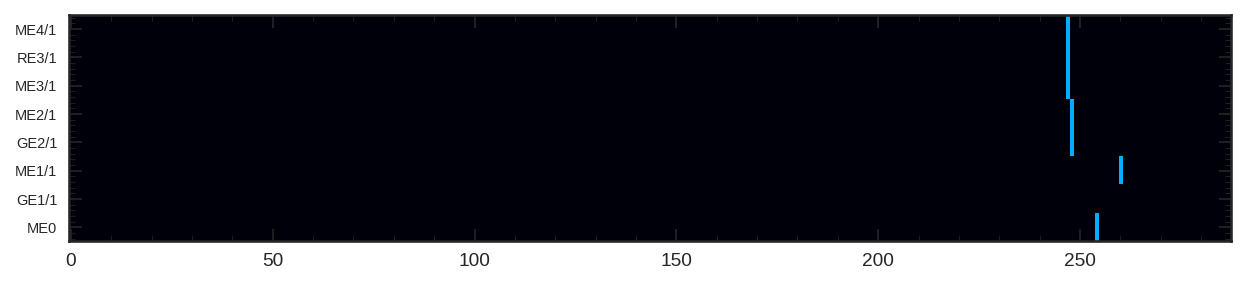

Event 3
pt: 3.808 eta: -2.102


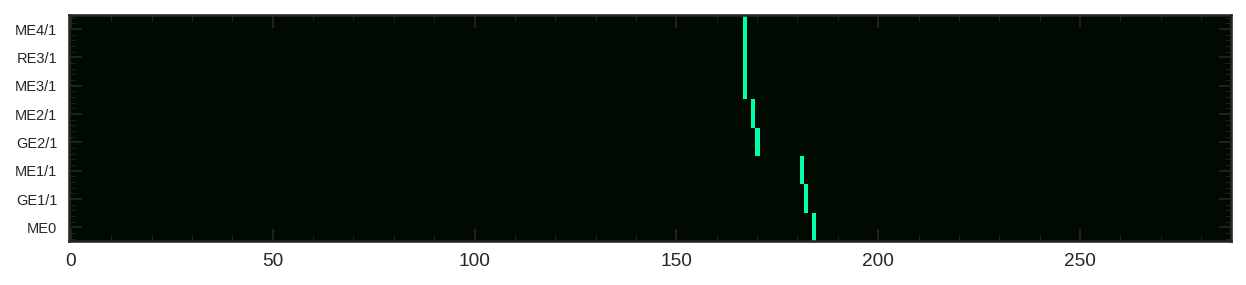

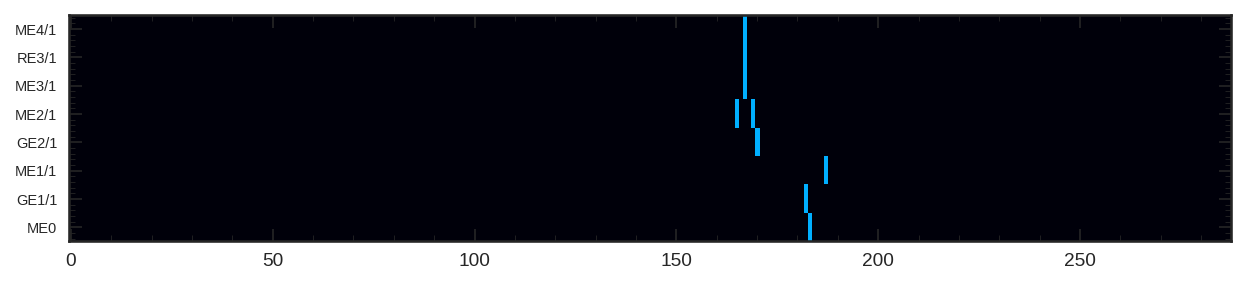

Event 4
pt: 2.784 eta: -2.162


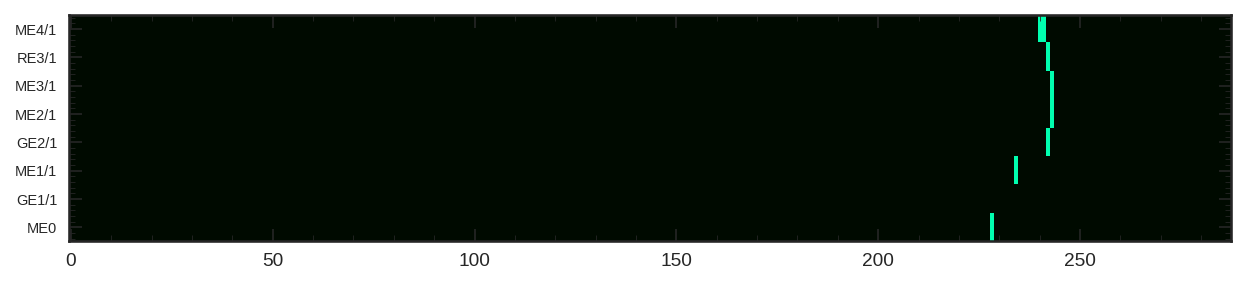

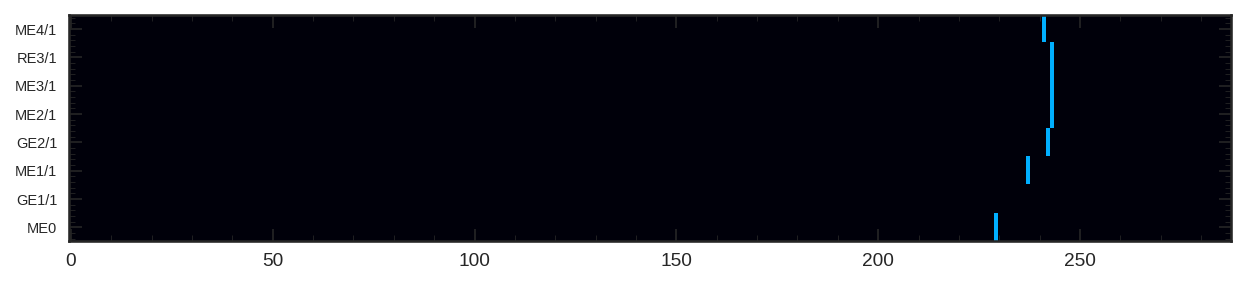

In [15]:
# Debug
for ievt in range(5):
  print('Event {}'.format(ievt))
  print('pt: {:.3f} eta: {:.3f}'.format(zone_part_pt_values[ievt], zone_part_eta_values[ievt]))
  display_zone_image(zone_images_gt[ievt], cmap=cm.green_hot)
  display_zone_image(zone_images[ievt])

In [16]:
# Build boxes

def get_box_ranges(anchors):
  start = np.maximum(0, anchors - box_col_offset)
  stop = np.minimum(num_cols, anchors + box_col_offset + 1)
  b_start = np.maximum(0, num_box_cols - stop)
  b_stop = np.minimum(num_box_cols, num_cols - start)
  return (start, stop, b_start, b_stop)


def build_boxes():
  # 5 indices: (dzero_bin, invpt_bin, img_row, img_col, img_channel)
  boxes = np.zeros((num_dzero_bins, num_invpt_bins) + box_image_format, dtype=np.float32)

  box_bins = digitize_d0_and_invpt(zone_part[:, part_fields.part_d0],
                                   zone_part[:, part_fields.part_invpt])
  box_bins_mir = ((num_dzero_bins - 1) - box_bins[0],
                  (num_invpt_bins - 1) - box_bins[1])

  # Canon images
  _build_boxes(zone_images_gt,
               box_bins,
               boxes)
  # Mirror images
  _build_boxes(zone_images_gt[:, :, ::-1, :],
               box_bins_mir,
               boxes)
  return (boxes, box_bins)


def _build_boxes(zone_images_gt,
                 box_bins,
                 boxes):
  def normalize(zone_images_gt):
    norm = zone_images_gt.sum(axis=-1).sum(axis=-1)  # reduce on axis=(-2,-1)
    norm[norm == 0] = 1
    zone_images_gt = zone_images_gt.astype(np.float32) / norm[:, :, np.newaxis, np.newaxis]
    return zone_images_gt

  def func(dzero_bin, invpt_bin, img, valid, start, stop, b_start, b_stop):
    # If anchor_row is valid, accumulate 'img' sliced from 'start' to 'stop'
    # into 'box' sliced from 'b_start' to 'b_stop'
    if valid:
      box = boxes[dzero_bin, invpt_bin]
      box[:, b_start:b_stop, 0] += img[:, start:stop, 0]

  anchors_valid = np.any(zone_images_gt[:, anchor_row, :, 0], axis=-1)
  anchors = np.argmax(zone_images_gt[:, anchor_row, :, 0], axis=-1)
  box_ranges = get_box_ranges(anchors)
  zone_images_gt = normalize(zone_images_gt)

  iterables = zip(box_bins[0], box_bins[1], zone_images_gt, anchors_valid,
                  box_ranges[0], box_ranges[1], box_ranges[2], box_ranges[3])
  more_itertools.consume(itertools.starmap(func, iterables))


def postprocess_boxes(boxes, antialias=True):
  tmp_boxes = boxes.copy()
  # Apply anti-aliasing to anchor_row (ME2) and anchor_row-1 (RE2 or GE2)
  if antialias:
    kernel = np.array([1., 2., 1.], dtype=boxes.dtype)
    kernel /= kernel.sum()
    for i in range(tmp_boxes.shape[0]):
      for j in range(tmp_boxes.shape[1]):
        for k in [anchor_row, anchor_row-1]:
          for l in range(1, tmp_boxes.shape[3]-1):
            window = boxes[i, j, k, (l-1):(l+2), 0]
            tmp_boxes[i, j, k, l, 0] = (window * kernel).sum()

  # Normalization
  norm = np.sqrt(np.square(tmp_boxes).sum(axis=-1).sum(axis=-1))
  norm[norm == 0] = 1
  tmp_boxes /= norm[:, :, :, np.newaxis, np.newaxis]
  return (tmp_boxes, boxes)

In [17]:
# Display boxes

def display_boxes(boxes, cmap=None, figsize=(7.5,7.5)):
  fig, axs = plt.subplots(num_dzero_bins, num_invpt_bins, figsize=figsize, sharex=True, sharey=True,
                          gridspec_kw=dict(wspace=0.1, hspace=0.1))
  for i in range(num_dzero_bins):
    for j in range(num_invpt_bins):
      ax = axs[(num_dzero_bins-1)-i, j]  # axs[0,0] is top left
      img = boxes[i, j]
      ax.imshow(img[..., 0], origin='lower', interpolation='none', aspect='auto', cmap=cmap)
      ax.set_xticklabels([])
      ax.set_yticklabels([])
      ax.grid(False)
      for x in [-40, -20, 0, +20, +40]:  # custom grid lines
        ax.axvline(box_col_offset+x, color='w', alpha=0.4, linewidth=0.5, linestyle=':')
  plt.show()

def display_box(img, cmap=None, figsize=(3,3)):
  fig, ax = plt.subplots(figsize=figsize)
  ax.imshow(img[..., 0], origin='lower', interpolation='none', aspect='auto', cmap=cmap)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.grid(False)
  for x in [-40, -20, 0, +20, +40]:  # custom grid lines
    ax.axvline(box_col_offset+x, color='w', alpha=0.4, linewidth=0.5, linestyle=':')
  plt.show()

In [18]:
%%time

boxes, box_bins = build_boxes()
boxes_norm, boxes = postprocess_boxes(boxes)

logger.info('boxes_norm: {} boxes: {}'.format(boxes_norm.shape, boxes.shape))

[INFO    ] boxes_norm: (7, 7, 8, 111, 1) boxes: (7, 7, 8, 111, 1)


CPU times: user 30.9 s, sys: 26.7 s, total: 57.5 s
Wall time: 57.6 s


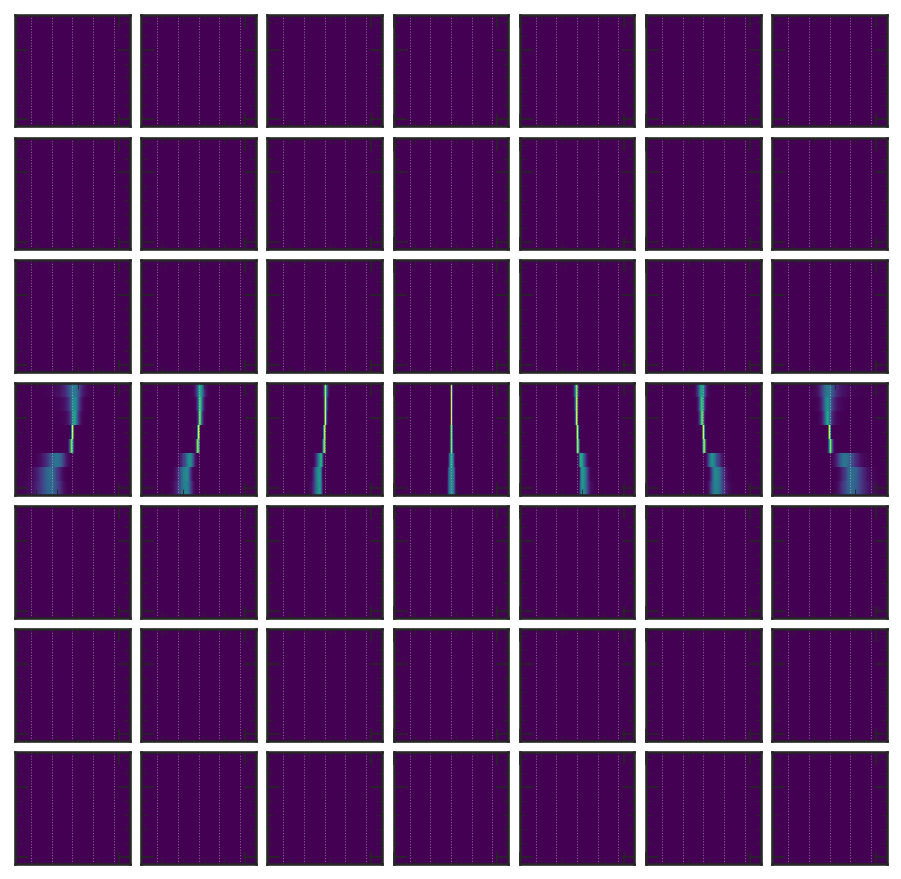

In [19]:
display_boxes(boxes_norm)

In [20]:
# Crop zone images using boxes

def build_crop_images():
  # crop_images_gt are made from sim hits, while crop_images are made from trigger primitives.
  # 'gt' stands for ground truth.
  crop_images_gt = np.zeros((zone_part.shape[0],) + box_image_format, dtype=bool)
  crop_images = np.zeros((zone_part.shape[0],) + box_image_format, dtype=bool)
  zone_images_anchors = np.zeros(zone_part.shape[0], dtype=np.int32)

  # Find zone_images_anchors
  _build_crop_images_0(zone_images_gt,
                       box_bins,
                       boxes_norm,
                       zone_images_anchors)

  # Build crop_images_gt
  _build_crop_images_1(zone_images_gt,
                       zone_images_anchors,
                       crop_images_gt)
  # Build crop_images
  _build_crop_images_1(zone_images,
                       zone_images_anchors,
                       crop_images)
  return (crop_images_gt, crop_images, zone_images_anchors)


def _build_crop_images_0(zone_images_gt,
                         box_bins,
                         boxes_norm,
                         zone_images_anchors):
  def func(ievt, dzero_bin, invpt_bin, img):
    # Pseudo 2D convolution by applying 1D convolution multiple times and summing the results
    # Note the box has to be flipped before 1D convolution
    box = boxes_norm[dzero_bin, invpt_bin]
    convolved = np.add.reduce([
        np.convolve(img[i, :, 0], box[i, ::-1, 0], mode='same')
        for i in range(img.shape[0])])
    # Get the best anchor_col
    zone_images_anchors[ievt] = np.argmax(convolved)

  iterables = zip(itertools.count(), box_bins[0], box_bins[1], zone_images_gt)
  more_itertools.consume(itertools.starmap(func, iterables))


def _build_crop_images_1(zone_images_gt,
                         zone_images_anchors,
                         crop_images_gt):
  def func(ievt, img, start, stop, b_start, b_stop):
    crop_images_gt[ievt, :, b_start:b_stop, 0] = img[:, start:stop, 0]

  box_ranges = get_box_ranges(zone_images_anchors)
  iterables = zip(itertools.count(), zone_images_gt, box_ranges[0], box_ranges[1],
                  box_ranges[2], box_ranges[3])
  more_itertools.consume(itertools.starmap(func, iterables))

In [21]:
%%time

crop_images_gt, crop_images, zone_images_anchors = build_crop_images()

logger.info('crop_images_gt: {} crop_images: {} zone_images_anchors: {}'.format(crop_images_gt.shape, crop_images.shape, zone_images_anchors.shape))

[INFO    ] crop_images_gt: (691542, 8, 111, 1) crop_images: (691542, 8, 111, 1) zone_images_anchors: (691542,)


CPU times: user 1min 32s, sys: 1.37 s, total: 1min 34s
Wall time: 1min 34s


Event 0
pt: 26.726 eta: -2.081


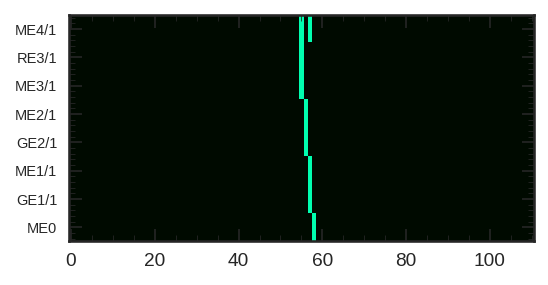

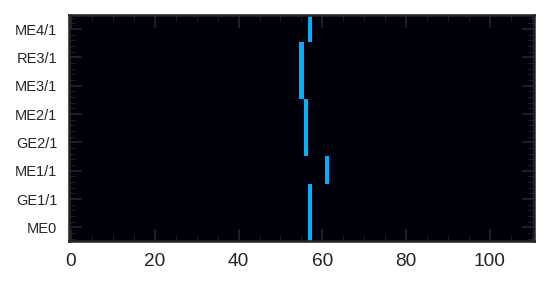

Event 1
pt: 2.550 eta: -2.306


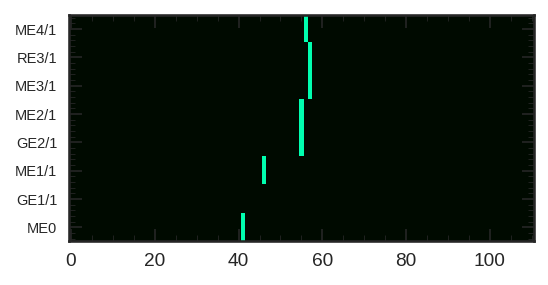

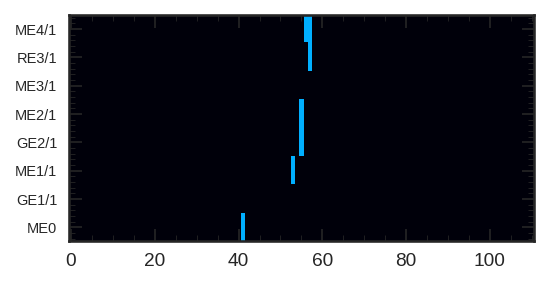

Event 2
pt: 3.003 eta: -2.355


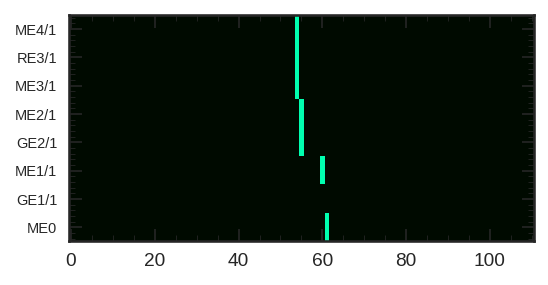

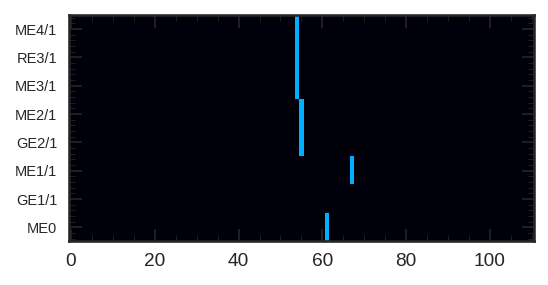

Event 3
pt: 3.808 eta: -2.102


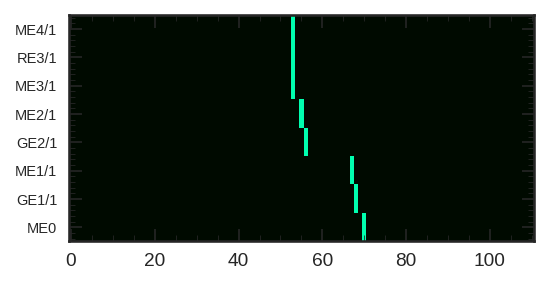

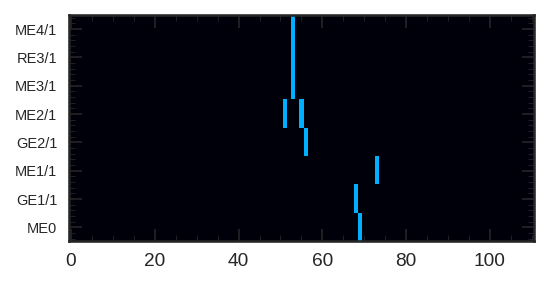

Event 4
pt: 2.784 eta: -2.162


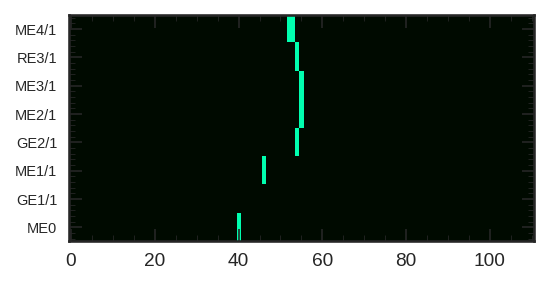

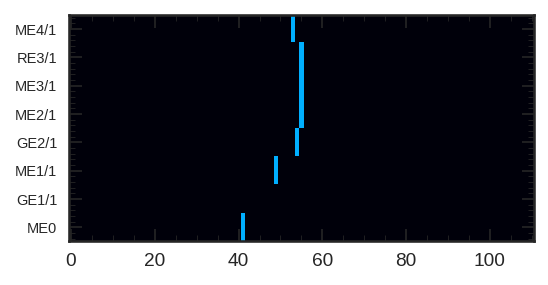

In [22]:
# Debug
for ievt in range(5):
  print('Event {}'.format(ievt))
  print('pt: {:.3f} eta: {:.3f}'.format(zone_part_pt_values[ievt], zone_part_eta_values[ievt]))
  display_zone_image(crop_images_gt[ievt], figsize=(4,2), cmap=cm.green_hot)
  display_zone_image(crop_images[ievt], figsize=(4,2))

In [23]:
# Debug
print(zone_images_anchors[:100])

[187  76 248 169 243 168 273 122  89  96 203 170 227 165 109 134 147  81
 173 249  54  57 159 265  88 221 170 210 224 201  39 270 269  82 208 248
 109 134 266  75 248 104  76 202 262  88 159 114 121 226 205 118 202 132
 198 143 192 114 200 116  86  39 252 133 228 273 201 161  77 198  73 193
 101 173  91 184 214  67 198 232 176 143 222 163 193  68 252 270 138 123
 200 260 232 214 250 193 235 131 239 207]


In [24]:
# Rebuild boxes from cropped images

def rebuild_boxes():
  # 5 indices: (dzero_bin, invpt_bin, img_row, img_col, img_channel)
  boxes = np.zeros((num_dzero_bins, num_invpt_bins) + box_image_format, dtype=np.float32)

  box_bins = digitize_d0_and_invpt(zone_part[:, part_fields.part_d0],
                                   zone_part[:, part_fields.part_invpt])
  box_bins_mir = ((num_dzero_bins - 1) - box_bins[0],
                  (num_invpt_bins - 1) - box_bins[1])

  # Canon images
  # Use crop_images as input (instead of crop_images_gt)
  _rebuild_boxes(crop_images,
                 box_bins,
                 boxes)
  # Mirror images
  _rebuild_boxes(crop_images[:, :, ::-1, :],
                 box_bins_mir,
                 boxes)
  return (boxes, box_bins)


def _rebuild_boxes(crop_images,
                   box_bins,
                   boxes):
  def func(dzero_bin, invpt_bin, img):
    box = boxes[dzero_bin, invpt_bin]
    box += img

  iterables = zip(box_bins[0], box_bins[1], crop_images)
  more_itertools.consume(itertools.starmap(func, iterables))

In [25]:
%%time

boxes, box_bins = rebuild_boxes()
boxes_norm, boxes = postprocess_boxes(boxes, antialias=False)

logger.info('boxes_norm: {} boxes: {}'.format(boxes_norm.shape, boxes.shape))

[INFO    ] boxes_norm: (7, 7, 8, 111, 1) boxes: (7, 7, 8, 111, 1)


CPU times: user 3.22 s, sys: 44.8 ms, total: 3.27 s
Wall time: 3.27 s


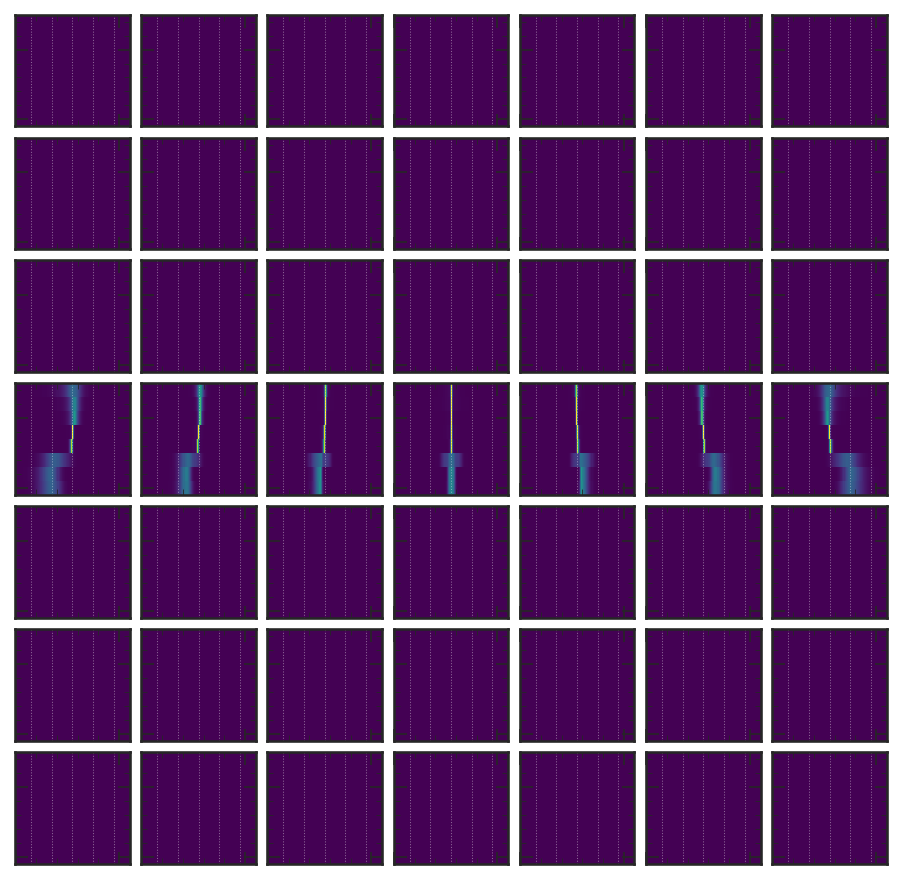

In [26]:
display_boxes(boxes_norm)

### Create patterns

In [27]:
# Apply activation threshold

boxes_act = (boxes_norm > activation)

# Detect weird spikes
def antispike():
  tmp_boxes = boxes_act.copy()
  for i in range(tmp_boxes.shape[0]):
    for j in range(tmp_boxes.shape[1]):
      for k in range(tmp_boxes.shape[2]):
        img = tmp_boxes[i, j, k, :, 0]
        for l in range(1, img.shape[0]-1):
          if img[l] and not img[l-1] and not img[l+1]:
            print('Found spike at {}'.format((i, j, k, l, 0)))


# Detect wide ranges
def antirange():
  tmp_boxes = boxes_act.copy()
  for i in range(tmp_boxes.shape[0]):
    for j in range(tmp_boxes.shape[1]):
      for k in range(tmp_boxes.shape[2]):
        img = tmp_boxes[i, j, k, :, 0]
        for l in range(1, img.shape[0]-1):
          if img[l] and ((l < (box_col_offset - box_col_padding)) or
                         (l > (box_col_offset + box_col_padding))):
            print('Found wide range at {}'.format((i, j, k, l, 0)))


antispike()
antirange()

In [28]:
# Ad-hoc fixes

if zone == 0:
  boxes_act[3, 0, 3, 56, 0] = 1  # GE2/1
  boxes_act[3, 1, 3, 56, 0] = 1  # GE2/1
  boxes_act[3, 5, 3, 54, 0] = 1  # GE2/1
  boxes_act[3, 6, 3, 54, 0] = 1  # GE2/1
elif zone == 1:
  boxes_act[3, 0, 4, 54, 0] = 1  # ME2/1
  boxes_act[3, 6, 4, 56, 0] = 1  # ME2/1
  #
  boxes_act[3, 0, 0, 42, 0] = 0  # GE1/1
  boxes_act[3, 0, 1, 45, 0] = 0  # ME1/1
  boxes_act[3, 6, 0, 68, 0] = 0  # GE1/1
  boxes_act[3, 6, 1, 65, 0] = 0  # ME1/1
  #
  boxes_act[3, 0, 0, 18, 0] = 0  # GE1/1
  boxes_act[3, 0, 1, 18, 0] = 0  # ME1/1
  boxes_act[3, 6, 0, 92, 0] = 0  # GE1/1
  boxes_act[3, 6, 1, 92, 0] = 0  # ME1/1
  #
  boxes_act[3, 0, 3, 58, 0] = 0  # GE2/1
  boxes_act[3, 1, 3, 56, 0] = 1  # GE2/1
  boxes_act[3, 2, 3, 56, 0] = 1  # GE2/1
  boxes_act[3, 4, 3, 54, 0] = 1  # GE2/1
  boxes_act[3, 5, 3, 54, 0] = 1  # GE2/1
  boxes_act[3, 6, 3, 52, 0] = 0  # GE2/1
elif zone == 2:
  boxes_act[3, 2, 4, 54, 0] = 1  # ME3/2
  boxes_act[3, 3, 4, 54, 0] = 1  # ME3/2
  boxes_act[3, 3, 4, 56, 0] = 1  # ME3/2
  boxes_act[3, 4, 4, 56, 0] = 1  # ME3/2
  #
  boxes_act[3, 0, 2, 58, 0] = 0  # RE2/2
  boxes_act[3, 0, 2, 59, 0] = 0  # RE2/2
  boxes_act[3, 6, 2, 52, 0] = 0  # RE2/2
  boxes_act[3, 6, 2, 51, 0] = 0  # RE2/2
  #
  boxes_act[3, 2, 0, 55, 0] = 1  # ME1/2
  boxes_act[3, 4, 0, 55, 0] = 1  # ME1/2

antispike()
antirange()

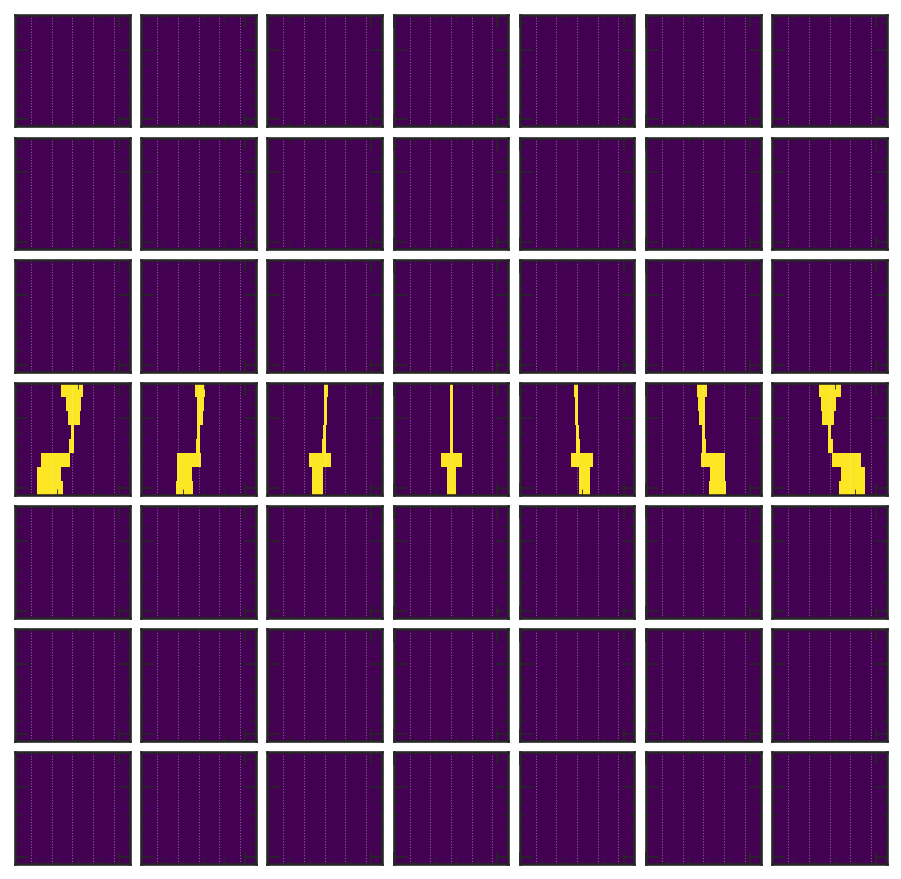

In [29]:
display_boxes(0.8 * boxes_act)

In [30]:
check_pattern_overlaps = False

if check_pattern_overlaps:
  display_box(0.5 * boxes_act[3,3], figsize=(2,2))
  display_box(0.5 * boxes_act[3,3] + 0.5 * boxes_act[3,4], figsize=(2,2))
  display_box(0.5 * boxes_act[3,4] + 0.5 * boxes_act[3,5], figsize=(2,2))
  display_box(0.5 * boxes_act[3,5] + 0.5 * boxes_act[3,6], figsize=(2,2))

In [31]:
check_efficiency_activation = False

if check_efficiency_activation:
  def find_efficiency_activation(tmp_boxes):
    # Count amount of activation before and after applying patterns
    denom = np.zeros((num_dzero_bins, num_invpt_bins), dtype=np.int32)
    numer = np.zeros((num_dzero_bins, num_invpt_bins), dtype=np.int32)

    for i in range(num_dzero_bins):
      for j in range(num_invpt_bins):
        mask = (box_bins[0] == i) & (box_bins[1] == j)
        tmp_images = crop_images[mask]
        tmp_box = tmp_boxes[i, j]
        denom[i, j] = tmp_images.any(axis=-1).any(axis=-1).sum(axis=-1).sum(axis=-1)
        numer[i, j] = (tmp_box & tmp_images).any(axis=-1).any(axis=-1).sum(axis=-1).sum(axis=-1)

    denom[denom == 0] = 1
    result = np.true_divide(numer, denom)
    return result.astype(np.float32)

  with np.printoptions(precision=5):
    for act in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1]:
      tmp_boxes = (boxes_norm > act)
      print(act)
      print(find_efficiency_activation(tmp_boxes))

In [32]:
check_d0_and_invpt_binning = False

if check_d0_and_invpt_binning:
  part_invpt_tmp = zone_part[:, part_fields.part_invpt]
  part_invpt_tmp = np.hstack((part_invpt_tmp, -part_invpt_tmp))
  part_dzero_tmp = zone_part[:, part_fields.part_d0]
  part_dzero_tmp = np.hstack((part_dzero_tmp, -part_dzero_tmp))
  with np.printoptions(precision=5):
    #q = np.percentile(part_invpt_tmp, [0.5,100./7,200./7,300./7,400./7,500./7,600./7,99.5], overwrite_input=True)
    #print('invpt_bins: {}'.format(q))
    #q = np.percentile(part_dzero_tmp, [0.5,300./12,500./12,588./12,612./12,700./12,900./12,99.5], overwrite_input=True)
    #print('dzero_bins: {}'.format(q))
    if zone == 0:
      q = np.percentile(part_invpt_tmp, [0.5, 18.75, 31.25, 43.75, 56.25, 68.75, 81.25, 99.5], overwrite_input=True)
    elif zone == 1:
      q = np.percentile(part_invpt_tmp, [0.5, 17.5, 30.0, 44.0, 56.0, 70.0, 82.5, 99.5], overwrite_input=True)
    elif zone == 2:
      q = np.percentile(part_invpt_tmp, [0.5, 18.75, 31.25, 42.5, 57.5, 68.75, 81.25, 99.5], overwrite_input=True)
    print('invpt_bins: {}'.format(q))

In [33]:
# Debug
for j in range(num_invpt_bins):
  print(1.0 * boxes_act[3, j, anchor_row, box_col_offset-10:box_col_offset+11].reshape(-1))  # ME2

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [34]:
# Debug
for j in range(num_invpt_bins):
  print(1.0 * boxes_act[3, j, anchor_row-1, box_col_offset-10:box_col_offset+11].reshape(-1))  # RE2 or GE2

[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]


In [35]:
# Create pattern windows

def create_patterns():
  # Find mid from the weighted mean (using boxes)
  patterns_mid = (boxes[..., 0] * (0.5 + np.arange(num_box_cols))).sum(axis=-1)  # reduce on axis=(-2,-1)
  norm = (boxes[..., 0]).sum(axis=-1)
  norm[norm == 0] = 1
  patterns_mid /= norm

  patterns_mid = patterns_mid.astype(np.int32)
  patterns_start = np.zeros(patterns_mid.shape, dtype=np.int32)
  patterns_stop = np.zeros(patterns_mid.shape, dtype=np.int32)
  assert np.all(patterns_mid[3, :, anchor_row] == box_col_offset)
  assert np.all(patterns_mid[3, 3, :] == box_col_offset)

  # Find start, stop (using boxes_act)
  for i in range(boxes_act.shape[0]):
    for j in range(boxes_act.shape[1]):
      for k in range(boxes_act.shape[2]):
        for l in range(boxes_act.shape[3]):
          if boxes_act[i, j, k, l, 0] == 1:
            patterns_start[i, j, k] = l
            break
        for l in reversed(range(boxes_act.shape[3])):
          if boxes_act[i, j, k, l, 0] == 1:
            patterns_stop[i, j, k] = l
            break

  patterns = np.stack([patterns_start, patterns_mid, patterns_stop])
  patterns = np.moveaxis(patterns, 0, -1)
  patterns_winsz = (patterns_stop - patterns_start + 1)
  patterns_winsz[patterns_winsz == 1] = 0
  assert np.all(patterns_winsz < ((box_col_padding * 2) + 1))

  # Sanity check by recreating boxes_act from patterns
  tmp_boxes = np.zeros(boxes_act.shape, dtype=boxes_act.dtype)
  for i in range(patterns.shape[0]):
    for j in range(patterns.shape[1]):
      for k in range(patterns.shape[2]):
        l0, l1, l2 = patterns[i, j, k]
        if l2 > l0:
          tmp_boxes[i, j, k, l0:l2+1, 0] = 1
  assert np.all(tmp_boxes == boxes_act)

  return (patterns, patterns_winsz)


patterns, patterns_winsz = create_patterns()

logger.info('patterns: {} patterns_winsz: {}'.format(patterns.shape, patterns_winsz.shape))

[INFO    ] patterns: (7, 7, 8, 3) patterns_winsz: (7, 7, 8)


In [36]:
# Debug
print(np.array2string(patterns[3, :], separator=', '))

[[[21, 33, 45],
  [21, 32, 43],
  [25, 38, 52],
  [52, 54, 56],
  [54, 55, 56],
  [51, 56, 62],
  [49, 56, 63],
  [44, 54, 65]],

 [[34, 42, 49],
  [35, 42, 48],
  [35, 45, 57],
  [53, 54, 56],
  [54, 55, 56],
  [54, 57, 59],
  [54, 57, 60],
  [52, 57, 61]],

 [[43, 49, 53],
  [43, 49, 53],
  [41, 50, 61],
  [53, 55, 56],
  [54, 55, 56],
  [55, 56, 57],
  [55, 56, 57],
  [55, 56, 58]],

 [[51, 55, 59],
  [51, 55, 59],
  [45, 55, 65],
  [54, 55, 56],
  [54, 55, 56],
  [54, 55, 56],
  [54, 55, 56],
  [54, 55, 56]],

 [[57, 61, 67],
  [57, 61, 67],
  [49, 60, 69],
  [54, 55, 57],
  [54, 55, 56],
  [53, 54, 55],
  [53, 54, 55],
  [52, 54, 55]],

 [[61, 68, 76],
  [62, 68, 75],
  [53, 65, 75],
  [54, 56, 57],
  [54, 55, 56],
  [51, 53, 56],
  [50, 53, 56],
  [49, 53, 58]],

 [[65, 77, 89],
  [67, 78, 89],
  [58, 72, 85],
  [54, 56, 58],
  [54, 55, 56],
  [48, 54, 59],
  [47, 54, 61],
  [45, 56, 66]]]


In [37]:
# Debug
print(np.array2string(patterns_winsz[3, :], separator=', '))

[[25, 23, 28,  5,  3, 12, 15, 22],
 [16, 14, 23,  4,  3,  6,  7, 10],
 [11, 11, 21,  4,  3,  3,  3,  4],
 [ 9,  9, 21,  3,  3,  3,  3,  3],
 [11, 11, 21,  4,  3,  3,  3,  4],
 [16, 14, 23,  4,  3,  6,  7, 10],
 [25, 23, 28,  5,  3, 12, 15, 22]]


In [38]:
# Create pattern quality

def create_patterns_quality():
  # Normalize once
  quality_adjust = np.true_divide(patterns_winsz, patterns_winsz[3, 3])
  # l2-sum over axis=-1
  quality_adjust = np.sqrt(np.square(quality_adjust).sum(axis=-1))
  # Normalize again
  quality_adjust_norm = quality_adjust.copy()
  quality_adjust_norm[quality_adjust_norm == 0] = 1
  quality_adjust[quality_adjust != 0] = quality_adjust[3, 3]
  quality_adjust /= quality_adjust_norm
  quality_adjust = np.expand_dims(quality_adjust, axis=-1)
  #print(quality_adjust[3, :])

  # Find hit bitmap
  accumulated_0 = np.zeros((num_dzero_bins, num_invpt_bins, (2 ** num_box_rows)), dtype=np.int64)
  accumulated_1 = accumulated_0.copy()  # cumulative version of accumulated_0
  po2_coeffs = (2 ** np.arange(num_box_rows))  # [1,2,4,8,16,32,64,128]

  for i in range(num_dzero_bins):
    for j in range(num_invpt_bins):
      mask = (box_bins[0] == i) & (box_bins[1] == j)
      tmp_images = crop_images[mask]
      if tmp_images.size > 0:
        # Reduce on axis=(-2,-1), then calc dot-product on axis=-3 (row)
        tmp_images_hitmap = (tmp_images.any(axis=-1).any(axis=-1) * po2_coeffs).sum(axis=-1)
        # np.bincount() is like np.histogram() for unit bin size
        accumulated_0[i, j] = np.bincount(tmp_images_hitmap)
  #print(accumulated_0[3, :])

  for i in range(num_dzero_bins):
    for j in range(num_invpt_bins):
      for lhs in range(accumulated_1.shape[-1]):
        for rhs in range(accumulated_1.shape[-1]):
          if (lhs & rhs) == rhs:
            accumulated_1[i, j, lhs] += accumulated_0[i, j, rhs]
  #print(accumulated_1[3, :])

  patterns_quality = (accumulated_1[3, :] * quality_adjust[3, :]).sum(axis=0)
  patterns_quality = patterns_quality.astype(np.float32)
  patterns_quality_indices = np.argsort(patterns_quality)
  patterns_quality_ranks = np.zeros(patterns_quality.shape, dtype=np.int32)
  patterns_quality_ranks[patterns_quality_indices] = np.arange(patterns_quality.shape[0])
  return (patterns_quality, patterns_quality_indices, patterns_quality_ranks)


patterns_quality, patterns_quality_indices, patterns_quality_ranks = create_patterns_quality()

In [39]:
# Debug
with np.printoptions(threshold=10):
  print(patterns_quality.shape, patterns_quality.min(), patterns_quality.max())
  print(patterns_quality)
  print(patterns_quality_indices)
  print(patterns_quality_ranks)
  print()
  for i in range(0, 256, 8):
    s = ' '.join(['{:08b}'] * 8)
    print(s.format(*patterns_quality_indices[i:i+8]))

(256,) 3.435053 380448.7
[3.4350531e+00 1.6711441e+02 6.0513163e+00 ... 2.0630125e+05 2.4545998e+04
 3.8044869e+05]
[  0  32 128 ... 223 253 255]
[  0  92   3 ... 254 250 255]

00000000 00100000 10000000 00000010 00100010 00001000 10000010 00101000
10001000 00001010 00010000 00101010 10001010 00110000 10010000 00010010
00110010 01000000 10010010 01000010 10100000 10100010 01100000 01001000
01100010 01001010 01010000 10101000 00000100 00100100 01010010 10000100
10101010 00010100 00001100 00101100 00110100 11000000 10010100 10001100
01000100 01101000 11000010 10110000 01101010 10100100 10110010 01100100
00011000 01010100 00000110 00100110 01110000 01110010 01001100 00011010
10000110 11001000 00111000 10101100 11000100 01000110 11001010 00001110
00010110 00111010 00101110 10011000 00110110 01100110 11010000 10100110
10110100 01101100 10001110 10010110 10011010 11010010 01110100 01010110
01001110 11000110 00011100 11001100 11010100 01011000 00111100 01101110
01011010 01110110 10101110 1001

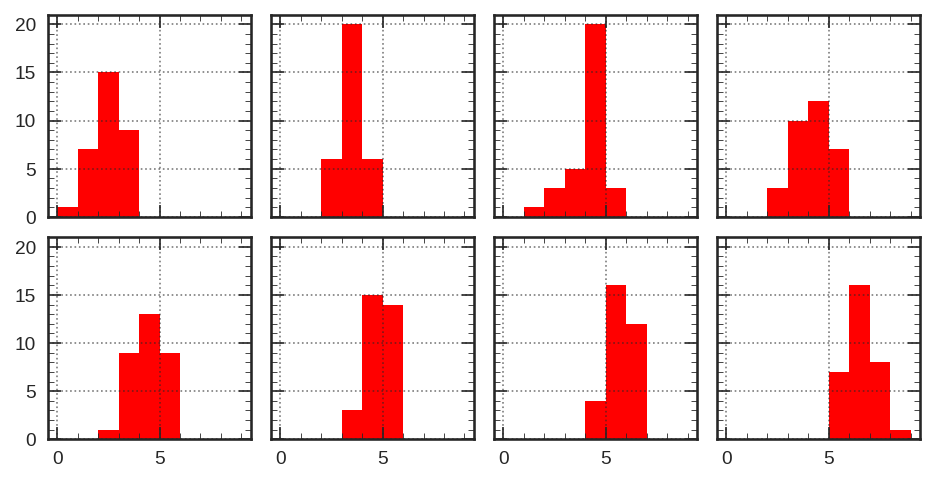

In [40]:
fig, axs = plt.subplots(2, 4, figsize=(7.5, 7.5/2), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.1))

for i in range(8):
  ax = axs[i//4, i%4]
  hist = np.zeros(num_box_rows + 1, dtype=np.int32)
  edges = np.arange(hist.shape[0] + 1)
  chunks = np.split(patterns_quality_indices, 8)
  for j in chunks[i]:
    kk = 0
    for k in range(num_box_rows):  # count num of set bits
      if j & (1 << k):
        kk += 1
    hist[kk] += 1

  hist_on_binned_data(hist, edges=edges, color='red', ax=ax)

plt.show()

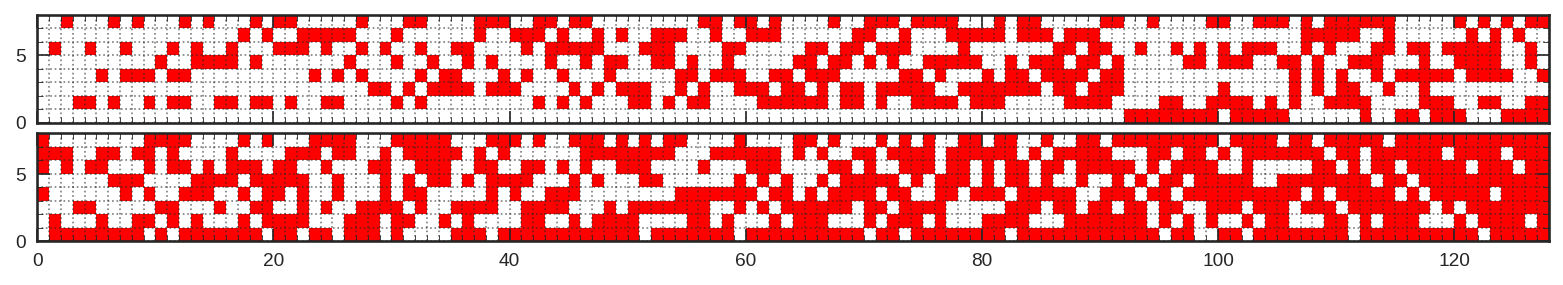

In [41]:
from matplotlib.ticker import AutoMinorLocator

fig, axs = plt.subplots(2, 1, figsize=(13, 2), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.1))

for i in range(2):
  ax = axs[i]
  hist = np.zeros((patterns_quality_indices.shape[0] // 2, num_box_rows), dtype=np.int32)
  xedges = np.arange(hist.shape[0] + 1)
  yedges = np.arange(hist.shape[1] + 1)
  chunks = np.split(patterns_quality_indices, 2)
  for j in chunks[i]:
    jj = patterns_quality_ranks[j] % (patterns_quality_indices.shape[0] // 2)
    for k in range(num_box_rows):  # check set bits
      if j & (1 << k):
        hist[jj, k] = 1

  hist2d_on_binned_data(hist, xedges=xedges, yedges=yedges, cmap=cm.red_binary, ax=ax)
  ax.grid(True, which='both')
  ax.xaxis.set_minor_locator(AutoMinorLocator(20))
  ax.yaxis.set_minor_locator(AutoMinorLocator(5))

plt.show()

In [42]:
# Write to file
outfile = 'patterns_zone%i.npz' % zone
outdict = {
  'patterns': patterns,
  'patt_filters': boxes_act,
  'patt_brightness': patterns_quality_ranks,
}
save_np_arrays(outfile, outdict)
logger.info('Wrote to {}'.format(outfile))

[INFO    ] Wrote to patterns_zone0.npz
